# Прогнозирование оттока клиентов из банка

Из «Бета-Банка» каждый месяц стали уходить клиенты. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Цель проекта**: построить модель с предельно большим значением *F1*-меры.

*План действий*:
- откроем данные и изучим общую информацию
- выполним предобработку
- подготовим признаки для машинного обучения
- исследуем баланс классов
- попробуем разные техники борьбы с дисбалансом
- протестируем лучшую выявленную модель

## Оглавление

1. [Подготовка данных](#step1)
    * [Откроем файл с данными и изучим общую информацию](#open) 
    * [Удаление ненужных столбцов](#del)
    * [Замена пропусков](#fillna)
    * [Провека на выбросы](#vibros)
    * [Прямое кодирование OHE](#ohe)
    * [Корреляция признаков](#corr)
    * [Разделение данных](#sepp)
    * [Стандартизация данных](#standrd)
    * [Вывод](#ouput1)
2. [Исследование задачи](#step2)
    * [Проверка баланса классов](#balance)
    * [Решающее дерево](#tree)
    * [Случайный лес](#forest)
    * [Логистическая регрессия](#logreg)
    * [Вывод](#ouput2)
3. [Борьба с дисбалансом](#fight)
    * [Взвешивание классов](#weight)
    * [Upsampling](#upsmpl)
    * [Downsampling](#downsmpl)
    * [Вывод](#ouput3)
4. [Тестирование модели](#step4)

<a id="step1"></a>
# Подготовка данных
<a id="open"></a>
## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd

data = pd.read_csv('/datasets/Churn.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Входные данные представляют собой таблицу, в которой каждая строка - наблюдение за одним из клиентов банка по 14 признакам.

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:
- Exited — факт ухода клиента

<a id="del"></a>
## Удаление ненужных столбцов

В таблице есть два столбца, которые не несут никакой полезной информации для модели: *RowNumber* просто дублирует индекс строки, *CustomerId* и *Surname* - по сути по-разному записанные имена клиентов, уж точно никак не влияют на уход клиента из банка. Поэтому удалим эти столбцы.

In [2]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<a id="fillna"></a>
## Замена пропусков

В столбце *Tenure* присутствуют пропуски. Их около 10%, поэтому удаление такой части данных будет неразумно. Заменим пропуски медианой. Такой подход учитывает имеющиеся данные и усредняет их.

In [3]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
#заодно приведем столбец к более читаемому виду
data['Tenure'] = data['Tenure'].astype('int')

#проверим, что пропусков не осталось
data['Tenure'].isna().sum()

0

<a id="vibros"></a>
## Проверка на выбросы

В количественных признаках возможно существуют выбросы. Их точно стоит проверить. Для этого посмотрим общую информацию о признаках и их распределения.

In [4]:
quantitative = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


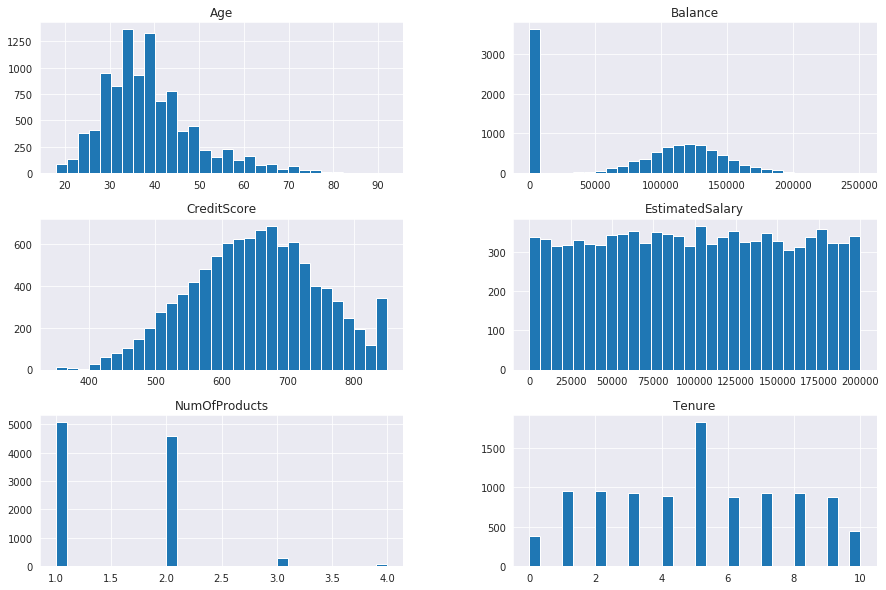

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

clm = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
data[clm].hist(bins=30, figsize=(15, 10))
plt.show()

В целом все значения в пределах разумного.

По возрасту: самому младшему кллиенту 18, а значит он совершеннолетний и уже может пользоваться услугами банка. Самому старшему - 92, это не выходит за рамки возможного.

Баланс на счете вообще распределен нормально, не учитывая пика в нуле. В данной задаче это не похоже на выброс. Так как нулевой баланс может быть сигналом, что человек вскоре перестанет пользоваться услугами банка.

Во всех остальных признаках тоже нет аномальных значений. А значит выбросы в данны отсутствуют

<a id="ohe"></a>
## Прямое кодирование *OHE*

Так как многие алгоритмы машинного обучение не умеют работать с объектами типа *object*, то преобразуем подобные столбцы в нашей таблице техникой прямого кодирования.

In [6]:
categorial = ['Geography', 'Gender']
#укажем параметр drop_first=True, чтобы не перегружать модель лишним столбцом
data = pd.get_dummies(data, columns=categorial, drop_first=True)
#посмотрим на новые столбцы
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


<a id="corr"></a>
## Корреляция признаков 

Сильно коррелирующие между собой признаки будут усложнять обучение модели. Проверим как коррелируеют признаки.

In [7]:
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.000000,-0.003965,-0.000060,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
Age,-0.003965,1.000000,-0.012606,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
Tenure,-0.000060,-0.012606,1.000000,-0.007535,0.011409,0.025979,-0.030681,0.010049,-0.015989,-0.003153,0.000772,0.012041
Balance,0.006268,0.028308,-0.007535,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
NumOfProducts,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
HasCrCard,-0.005458,-0.011721,0.025979,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
IsActiveMember,0.025651,0.085472,-0.030681,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
EstimatedSalary,-0.001384,-0.007201,0.010049,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112
Exited,-0.027094,0.285323,-0.015989,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.173488,-0.052667,-0.106512
Geography_Germany,0.005538,0.046897,-0.003153,0.401110,-0.010419,0.010577,-0.020486,0.010297,0.173488,1.000000,-0.332084,-0.024628


Максимальная корреляция достигает 0.4 . Это очень слабый показатель поэтому мы оставляем все признаки.

<a id="sepp"></a>
## Разделение данных

Разделим данные на обучающую, валидационную и тестовые выборки.

In [8]:
from sklearn.model_selection import train_test_split

#разделим в пропорции 60:20:20
train, other = train_test_split(data, test_size=0.4, random_state=5, stratify=data['Exited'])
valid, test = train_test_split(other, test_size=0.5, random_state=5, stratify=other['Exited'])

features_train = train.drop('Exited', axis=1)
target_train = train['Exited']

features_valid = valid.drop('Exited', axis=1)
target_valid = valid['Exited']

features_test = test.drop('Exited', axis=1)
target_test = test['Exited']

<a id="standrd"></a>
## Стандартизация данных

В исследовании мы будем использовать модель логистической регресси, которая, в отличие от деревьев, чувствительна к разным масштабам количественных признаков - она может посчитать какие-то признаки более весомее, чем другие. Чтобы избежать подобного, стандартизируем данные.

In [9]:
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment=None

#выделим количественные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
#обучим на тренировочных данных
scaler.fit(features_train[numeric])
#стандартизируем численные признаки в признаках для обучения
features_train[numeric] = scaler.transform(features_train[numeric])

#сразу же стандартизируем и признаки валидационной и тестовой выборок
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


<a id="ouput1"></a>
## Вывод:

Нами были прочитаны данные и краткая информация о них. Затем подготовили данные для обучения моделей:
- удалили ненужные столбцы
- заполнили пропуски
- проверили на выбросы
- преобразовали данные в понятный для алгоритма формат
- убедились, что нет сильно коррелирующих признаков
- разделили данные на обучающую, валидационую и тестовую выборки

Мы никак не обрабатывали столбцы HasCrCard и IsActiveMember. Данные в них представленны уже в удовлетворительном бинарном виде.

<a id="step2"></a>
# Исследование задачи
<a id="balance"></a>
## Проверка баланса классов

In [10]:
target_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

Результат показал, что классы находятся в дисбалансе.

Посмотрим какие будут метрики качества, если оставить дисбаланс.

Будем использовать три алгоритма машинного обучения: *решающее дерево*, *случаный лес* и *логиситческую регрессию*. Для сравнения моделей будем использовать две метрики качества: *F1-меру* и *AUC-ROC*.

<a id="tree"></a>
## Решающее дерево

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

best_f1 = 0
#перебором найдем лучшую глубину дерева и выведем результат на экран
for depth in range(2, 20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=5)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    #посчитаем значение F1меры
    f1 = f1_score(y_true = target_valid, y_pred = predictions)
    
    #теперь узнаем AUC-ROC: сначала посчитаем вероятности классов
    proba = model.predict_proba(features_valid)
    #выделим из них положительные 
    proba_one = proba[:, 1]
    #и посчитаем саму метрику 
    auc_roc = roc_auc_score(target_valid, proba_one)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        best_auc_roc = auc_roc

print('Лучший результат F1 =', best_f1, '| глубина =', best_depth, '| AUC-ROC =', best_auc_roc)

Лучший результат F1 = 0.5714285714285714 | глубина = 8 | AUC-ROC = 0.8307089832513561


<a id="forest"></a>
## Случайный лес

In [12]:
from sklearn.ensemble import RandomForestClassifier

best_f1 = 0
#циклом переберем гипермапареметры: количество решающих деревьев и глубину дерева, выведем параметры модели с лучшим результатом
for estim in range(10, 111, 5):
    for depth in range(5, 16):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=5)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(y_true = target_valid, y_pred = predictions)
        
        proba = model.predict_proba(features_valid)
        proba_one = proba[:, 1]
        auc_roc = roc_auc_score(target_valid, proba_one)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_estim = estim
            best_auc_roc = auc_roc
            
print('Лучший результат F1 =', best_f1, '| количество деревьев =', best_estim, '| глубина =', best_depth,
      '| AUC-ROC =', best_auc_roc)

Лучший результат F1 = 0.5882352941176471 | количество деревьев = 20 | глубина = 15 | AUC-ROC = 0.842372418643605


<a id="logreg"></a>
## Логистическая регрессия

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=5)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

f1 = f1_score(y_true = target_valid, y_pred = predictions)

proba = model.predict_proba(features_valid)
proba_one = proba[:, 1]
auc_roc = roc_auc_score(target_valid, proba_one)

print('F1 =', f1, '| AUC-ROC =', auc_roc)

F1 = 0.29259259259259257 | AUC-ROC = 0.7772672518435231


<a id="ouput2"></a>
## Вывод:

Мы выявили, что классы целевого признака находятся в дисбалансе - соотношение 8:2.

Не изменяя баланса классов, мы протестировали на данных три вида алгоритмов машинного обучения: *решающее дерево*, *случаный лес* и *логиситческую регрессию*. Для решающего девера и случайного леса подобрали лучшие гиперпараметры. После вычислили значения метрик качества F1 и AUC-ROC.

Каждая модель работает лучше чем случайная.

**Лучшей моделью оказалась модель случаного леса с гиперпараметрами: количество деревьев = 90 и глубина = 13**. **Её метрики качества получились: F1 = 0.588, AUC-ROC = 0.84**.

Немного хуже справилась модель решающего дерева: F1 = 0.571 | AUC-ROC = 0.83.
Хуже всех показала себя логистическая регрессия: F1 = 0.293 | AUC-ROC = 0.78.

<a id="fight"></a>
# Борьба с дисбалансом

Для упрощения работы напишем три функции, которые будут возвращать нам модели с лучшими результатами для каждого из выбранных алгоритмов.

In [14]:
def tree_results(features_train, target_train, features_valid, target_valid, clas_weight):
    '''
    функция подбора лучших гиперпараметров для алгоритма решающего дерева
    функция перебирает разные глубины дерева решений и возвращает лучшую модель по метрике f1,
    дополнительно возвращает параметры и AUC-ROC
    '''
    best_f1 = 0
    for depth in range(1, 20):
        model = DecisionTreeClassifier(max_depth=depth, random_state=5, class_weight=clas_weight)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(y_true = target_valid, y_pred = predictions)
        
        proba = model.predict_proba(features_valid)
        proba_one = proba[:, 1]
        auc_roc = roc_auc_score(target_valid, proba_one)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_auc_roc = auc_roc
    print('ДЕРЕВО РЕШЕНИЙ          | F1 =', best_f1, '| AUC-ROC =', best_auc_roc, '| глубина =', best_depth)
#-----------------------------------------------------------------------------------------------------------------------
def forest_results(features_train, target_train, features_valid, target_valid, clas_weight):
    '''
    функция подбора лучших гиперпараметров для алгоритма случайного леса
    функция перебирает разные глубины дерева решений и количества решающих деревьев, и возвращает лучшую модель по метрике f1,
    дополнительно возвращает параметры модели и AUC-ROC
    '''
    best_f1 = 0
    for estim in range(30, 111, 5):
        for depth in range(5, 16):
            model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=5, class_weight=clas_weight)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            
            f1 = f1_score(y_true = target_valid, y_pred = predictions)
            
            proba = model.predict_proba(features_valid)
            proba_one = proba[:, 1]
            auc_roc = roc_auc_score(target_valid, proba_one)
            if f1 > best_f1:
                best_f1 = f1
                best_depth = depth
                best_estim = estim
                best_auc_roc = auc_roc      
    print('СЛУЧАЙНЫЙ ЛЕС           | F1 =', best_f1, '| AUC-ROC =', best_auc_roc,
          '| количество деревьев =', best_estim, '| глубина =', best_depth)
#-----------------------------------------------------------------------------------------------------------------------
def logreg_results(features_train, target_train, features_valid, target_valid, clas_weight):
    '''
    функция возвращает результаты f1 и AUC-ROC для модели обученной с помощью логистической регрессии
    '''
    model = LogisticRegression(solver='liblinear', random_state=5, class_weight=clas_weight)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    f1 = f1_score(y_true = target_valid, y_pred = predictions)
    
    proba = model.predict_proba(features_valid)
    proba_one = proba[:, 1]
    auc_roc = roc_auc_score(target_valid, proba_one)

    print('ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ | F1 =', f1, '| AUC-ROC =', auc_roc)

<a id="weight"></a>
## Взвешивание классов

Сначала попробуем способ, который рассчитает и сам установит веса классов, тем самым сбалансируя их. Для этого будем указывать *class_weight='balanced'* при создании каждой модели.

In [15]:
tree_results(features_train, target_train, features_valid, target_valid, 'balanced')
forest_results(features_train, target_train, features_valid, target_valid, 'balanced')
logreg_results(features_train, target_train, features_valid, target_valid, 'balanced')

ДЕРЕВО РЕШЕНИЙ          | F1 = 0.5956175298804781 | AUC-ROC = 0.8316621706452215 | глубина = 7
СЛУЧАЙНЫЙ ЛЕС           | F1 = 0.6220735785953178 | AUC-ROC = 0.8601837584888432 | количество деревьев = 35 | глубина = 7
ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ | F1 = 0.5054545454545455 | AUC-ROC = 0.7786954905598974


Данным способом нам удалось значительно увеличить показатели качества. Фаворитом все так же остается случайный лес, его F1-мера возросла на приблизительно на 5% по сравнению с результатами без балансировки.

<a id="upsmpl"></a>
## Upsampling

Теперь попробуем технику увеличения выборки. Увеличим количество положительных ответов настолько, чтобы приблизительно сравнять его с  количеством отрицательными.

In [16]:
from sklearn.utils import shuffle

#сначала разделим положительные и отрицательные ответы
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

#здесь посчитаем во сколько раз нужно увеличить положительные ответы и
#окргулим в большую сторону, потому что датафреймы можно умножать только на целые числа
repeat = round((len(features_zeros) / len(features_ones)))

#в новые переменные поместим ( [все отрицательные] + [все положительные] * на нужное для уравнения количество раз)
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat )
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat ) 

#перемешаем объекты, чтобы модель лучше обучалась
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=5)

Найдем лучшие модели для данных, преобразованных техникой *upsampling*.

In [17]:
tree_results(features_upsampled, target_upsampled, features_valid, target_valid, None)
forest_results(features_upsampled, target_upsampled, features_valid, target_valid, None)
logreg_results(features_upsampled, target_upsampled, features_valid, target_valid, None)

ДЕРЕВО РЕШЕНИЙ          | F1 = 0.594810379241517 | AUC-ROC = 0.8300426775003045 | глубина = 7
СЛУЧАЙНЫЙ ЛЕС           | F1 = 0.6338672768878719 | AUC-ROC = 0.8614623868861156 | количество деревьев = 65 | глубина = 10
ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ | F1 = 0.5085049239033124 | AUC-ROC = 0.7787448465414568


Результаты так же лучше чем без балансировки. Также подросли метрики качества по сравнению с методом взвешивания классов.

<a id="downsmpl"></a>
## Downsampling

Попробуем еще одну похожую технику. Суть ее заключается в уменьшении количества объектов большего класса настолько, чтобы их количество приблизительно сравнялось с меньшим классом.

In [18]:
from sklearn.utils import shuffle

#посчитаем какую часть данных нужно оставить
fraction = len(features_ones) / len(features_zeros)

#объединим положительные ответы с нужной частью отрицательных
features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=5)] + [features_ones])
target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=5)] + [target_ones])

#также перемешаем
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=5)

Найдем лучшие модели для данных, преобразованных техникой *downsampling*.

In [19]:
tree_results(features_downsampled, target_downsampled, features_valid, target_valid, None)
forest_results(features_downsampled, target_downsampled, features_valid, target_valid, None)
logreg_results(features_downsampled, target_downsampled, features_valid, target_valid, None)

ДЕРЕВО РЕШЕНИЙ          | F1 = 0.5796460176991151 | AUC-ROC = 0.813698135732034 | глубина = 5
СЛУЧАЙНЫЙ ЛЕС           | F1 = 0.6235662148070906 | AUC-ROC = 0.8591704184924522 | количество деревьев = 110 | глубина = 7
ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ | F1 = 0.5077343039126478 | AUC-ROC = 0.7770050481914887


Результаты все так же лучше, чем без балансировки. Но данная техника борьбы с дисбалансом показала себя немного хуже, нежели две предыдущие.

<a id="ouput3"></a>
## Вывод

С целью решения проблемы дисбаланса классов целевого признака мы попробовали три техники: взвешивание классов, upsampling и downsampling. Применяя каждую технику, мы нашли результаты метрик качества для трех лучших моделей, обученных разными алгоритмами.

Каждая модель работает лучше случайной.

Но лучший результат был достигнут с помощью **техники upsampling у модели случайного леса с гиперпараметрами: количество деревьев = 65 | глубина = 10. Метрики качества: F1 = 0.6339 , AUC-ROC = 0.8615.**

<a id="step4"></a>
# Тестирование модели

Осталось лишь протестировать выявленную лучшую модель на тестовых данных.

In [20]:
model = RandomForestClassifier(n_estimators=65, max_depth=10, random_state=5)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)

f1 = f1_score(y_true = target_test, y_pred = predictions)

proba = model.predict_proba(features_test)
proba_one = proba[:, 1]
auc_roc = roc_auc_score(target_test, proba_one)

print('F1 =', f1, '| AUC-ROC =', auc_roc)

F1 = 0.6039823008849557 | AUC-ROC = 0.8646649300423688


# Общий вывод:

Входные данные представляли собой таблицу, в которой каждый объект представлял собой наблюдение за одинм клиентом банка по 14-ти признакам.

Данные были преобработаны и подготовлены для обучения на трех алгоритмах машинного обучения: *решающее дерево*, *случаный лес* и *логиситческая регрессия*.

Было выявленно, что классы целевого признака находятся в дисбалансе. Сначала мы попробовали решить задачу без учета дисбаланса, но, не получив нужных результатов по метрикам качества, было принято решение сбалансировать классы. 

Балансировка осуществлялась тремя техниками: *взвешиванием классов, upsampling* и *downsampling*. Для каждой из техник были выявлены лучшие модели по выбранным алгоритмам.

Лучше всех себя показала **модель случайного леса с гиперпараметрами: количество деревьев = 65 | глубина = 10, которая была обучена на данных, сбаласированных техникой upsampling**.

На тестовой выборке данная модель показала результаты: **F1 = 0.605 и AUC-ROC = 0.869**.